*Лабораторная работа № 2*

Ольшанов Александр Евгеньевич, группа 2374

Пометки:

Моё устройство - это ноутбук - его видиокарта не предназначена для таких нагрузок как обучение моделей - поэтому применена оптимизация для ускорения времени работы. Как результат падает точность. 
В работу берутся максимум 20 файлов для каждого вида птиц. Количество эпох модели 30. 

Среди данных 2 лабораторной работы - есть данные для обучения, однако тестовые данных отсутствуют - это сделано организаторами конкурса, чтобы никто не знал по каким данным будует вести оценка.

Решение - в данной работе обучающие данные - папка train_soundscapes будет разделена на 2 группы - данные для обучения и тестовые данные. Обычно разделение происходит на данные для обучения и для предтестового прогона, однако в сложившихся обстаятельствах - этот этап будет пропущен.

**Подключение необходимых библиотек**

In [1]:
import pandas as pd
import numpy as np
import librosa
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


1. Анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка
train_meta = pd.read_csv('birdclef-2021/train_metadata.csv')
train_soundscapes = pd.read_csv('birdclef-2021/train_soundscape_labels.csv')

print("1. train_metadata.csv (отедельные птицы):")
print(f"Количество записей: {len(train_meta)}")
print(f"Количество уникальных птиц: {train_meta['primary_label'].nunique()}")

print("\n2. train_soundscape_labels.csv (записи с природой):")
print(f"Количество 5-секундных окон: {len(train_soundscapes)}")
print(f"Количество аудиофайлов: {train_soundscapes['audio_id'].nunique()}")

print("\n3. Распределение классов птиц:")
bird_counts = train_meta['primary_label'].value_counts()
print(bird_counts)

1. train_metadata.csv (отедельные птицы):
Количество записей: 62874
Количество уникальных птиц: 397

2. train_soundscape_labels.csv (записи с природой):
Количество 5-секундных окон: 2400
Количество аудиофайлов: 20

3. Распределение классов птиц:
primary_label
barswa     500
sonspa     500
spotow     500
redcro     500
rewbla     500
          ... 
whcpar      12
wegspa1     10
runwre1      9
stvhum2      8
crfpar       8
Name: count, Length: 397, dtype: int64


2. Подготовка данных

In [14]:
import os
from tqdm import tqdm

print("\nСбор файлов")

audio_files = []
labels = []
files_per_bird = 20

for bird in tqdm(all_birds, desc="Обработка папок с птицами"):
    bird_folder = os.path.join(audio_folder, bird)
    if os.path.exists(bird_folder):
        files = [f for f in os.listdir(bird_folder) if f.endswith('.ogg')]
        
        files_to_take = min(files_per_bird, len(files))
        
        for i in range(files_to_take):
            audio_files.append(os.path.join(bird_folder, files[i]))
            labels.append(bird)

print(f"\nИтого собрано файлов: {len(audio_files)}")
print(f"Уникальных меток (птиц): {len(set(labels))}")

train_data = pd.DataFrame({
    'file_path': audio_files,
    'label': labels
})

print(f"\nИтоговая структура данных:")
print(f"Общее количество файлов: {len(train_data)}")
print(f"Количество классов (птиц): {train_data['label'].nunique()}")


Сбор файлов


Обработка папок с птицами: 100%|██████████| 397/397 [00:00<00:00, 4261.83it/s]


Итого собрано файлов: 7884
Уникальных меток (птиц): 397

Итоговая структура данных:
Общее количество файлов: 7884
Количество классов (птиц): 397


3. Извлечение признаков (лог-мел-спектрограммы)

In [ ]:
import numpy as np
import librosa

def extract_mel_spectrogram(file_path, sr=32000, duration=5.0, n_mels=128):
    audio, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    if len(audio) < int(sr * duration):
        audio = np.pad(audio, (0, int(sr * duration) - len(audio)))
    
    mel_spec = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr, 
        n_mels=n_mels,
        n_fft=2048,
        hop_length=512
    )
    
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    
    return log_mel_spec

features = []
print("Извлечение мел-спектрограмм...")

for file_path in tqdm(train_data['file_path'], desc="Обработка аудио"):
    try:
        mel_spec = extract_mel_spectrogram(file_path)
        features.append(mel_spec)
    except Exception as e:
        print(f"Ошибка с файлом {file_path}: {e}")
        features.append(np.zeros((128, 157)))

X = np.array(features)
print(f"\nРазмерность признаков X: {X.shape}")

y = train_data['label'].values
print(f"Размерность меток y: {y.shape}")


=== ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ ===
Извлечение мел-спектрограмм...


Обработка аудио: 100%|██████████| 7884/7884 [04:55<00:00, 26.65it/s]



Размерность признаков X: (7884, 128, 313)
Размерность меток y: (7884,)


Визуализируем первые 5 файлов:

Аудио 1:
  Файл: XC109605.ogg
  Птица: acafly


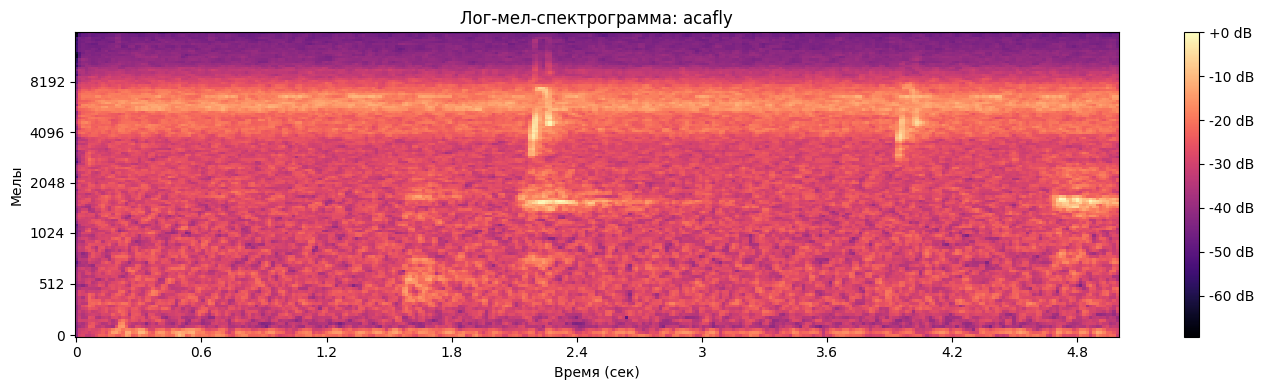

Аудио 2:
  Файл: XC11209.ogg
  Птица: acafly


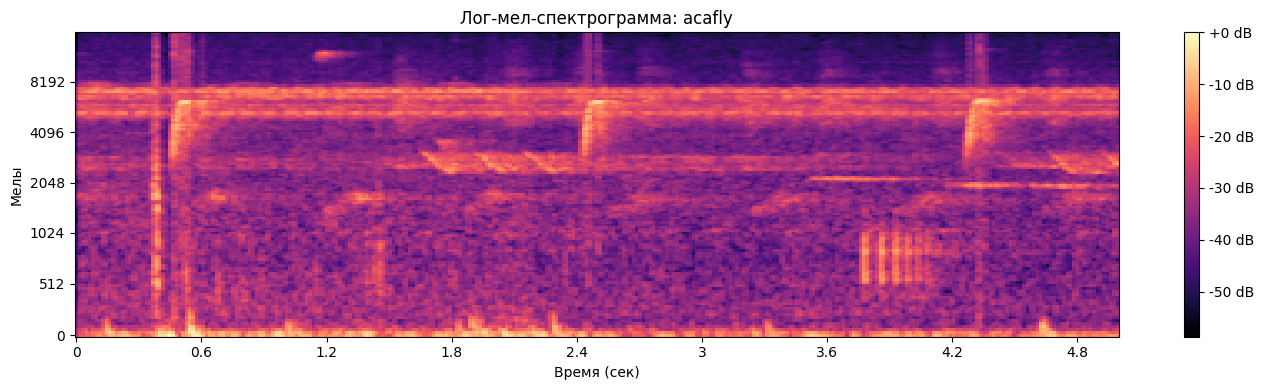

Аудио 3:
  Файл: XC127032.ogg
  Птица: acafly


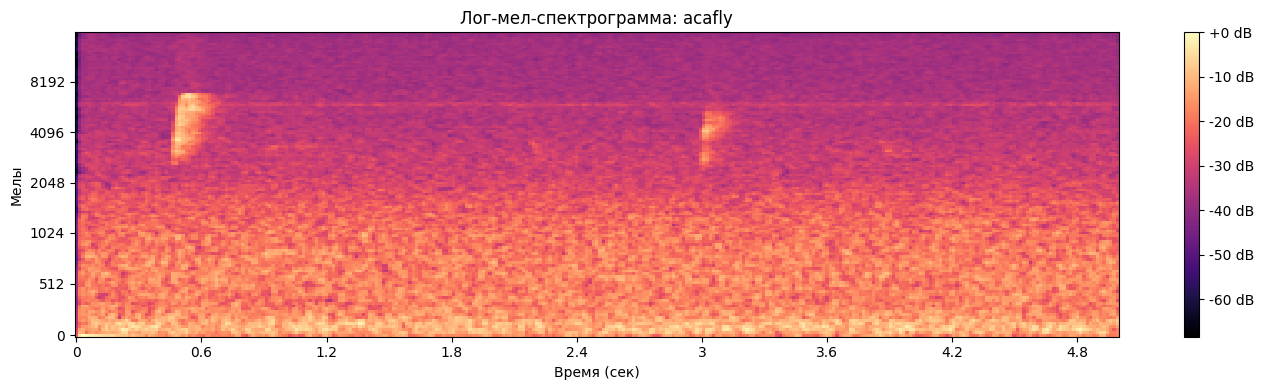

Аудио 4:
  Файл: XC129974.ogg
  Птица: acafly


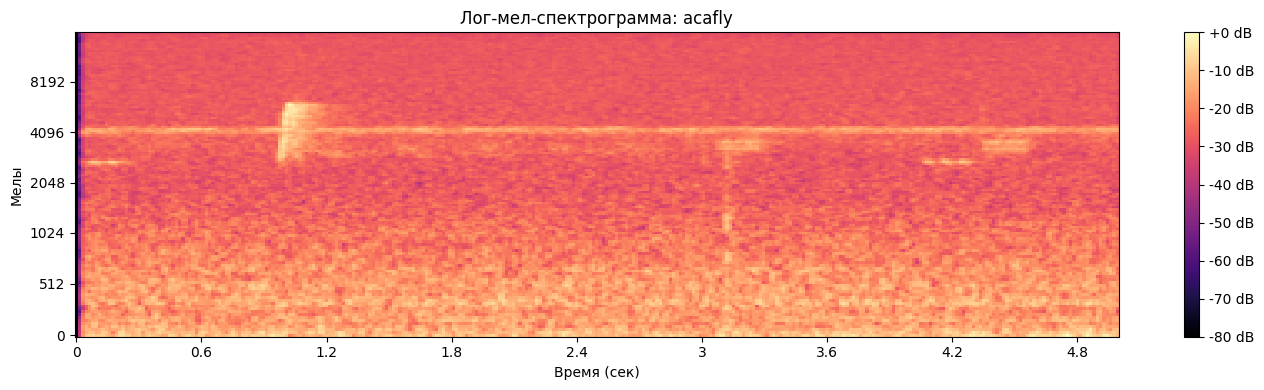

Аудио 5:
  Файл: XC129981.ogg
  Птица: acafly


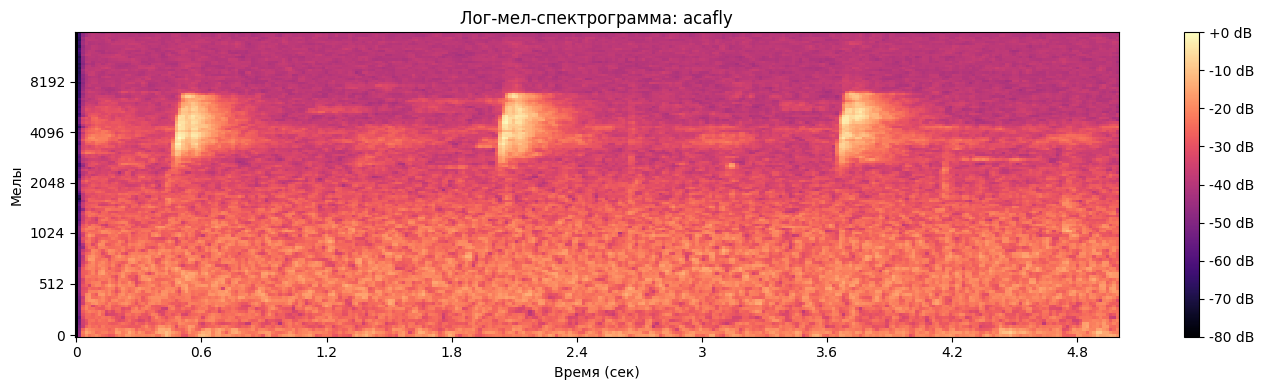

In [19]:
import matplotlib.pyplot as plt
import librosa.display

def visualize_mel_spectrogram(spectrogram, label, sample_rate=32000):
    plt.figure(figsize=(14, 4))
    
    librosa.display.specshow(
        spectrogram, 
        x_axis='time',
        y_axis='mel',
        sr=sample_rate,
        hop_length=512
    )
    
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Лог-мел-спектрограмма: {label}')
    plt.xlabel('Время (сек)')
    plt.ylabel('Мелы')
    plt.tight_layout()
    plt.show()

for i in range(5):
    file_path = train_data.iloc[i]['file_path']
    label = train_data.iloc[i]['label']
    
    print(f"Аудио {i+1}:")
    print(f"  Файл: {os.path.basename(file_path)}")
    print(f"  Птица: {label}")
    
    visualize_mel_spectrogram(X[i], label)

Все вышеприведённые спектограммы относятся к одной и той же птице - на них видно, что звук издаваемый птицей имеет схожую форму на спекограмме

4. Подготовка меток

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Текстовые метки в числа
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

num_classes = len(label_encoder.classes_)
print(f"Количество классов: {num_classes}")

y_onehot = to_categorical(y_encoded, num_classes=num_classes)

print(f"\nРазмерности данных:")
print(f"Признаки X: {X.shape}")
print(f"Метки y (текстовые): {y.shape}")
print(f"Метки y (one-hot): {y_onehot.shape}")

Количество классов: 397

Размерности данных:
Признаки X: (7884, 128, 313)
Метки y (текстовые): (7884,)
Метки y (one-hot): (7884, 397)


5. Разделение данных(80 и 20)

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Для соответствие формату - добавим размерность каналов
X_with_channels = X[..., np.newaxis]
print(f"X с каналами: {X_with_channels.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_with_channels, 
    y_onehot, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"Обучающая выборка (train): {X_train.shape} {y_train.shape}")
print(f"Тестовая выборка (test):   {X_test.shape} {y_test.shape}")

print(f"\nПроцентное соотношение:")
print(f"Train: {len(X_train)/len(X)*100:.1f}%")
print(f"Test:  {len(X_test)/len(X)*100:.1f}%")

X с каналами: (7884, 128, 313, 1)
Обучающая выборка (train): (6307, 128, 313, 1) (6307, 397)
Тестовая выборка (test):   (1577, 128, 313, 1) (1577, 397)

Процентное соотношение:
Train: 80.0%
Test:  20.0%


6. Создание модели

In [26]:
from tensorflow.keras import layers, models


input_shape = X_train.shape[1:]  # (128, 157, 1)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax')
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Архитектура модели создана")

Архитектура модели создана


7. Обучение модели

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks для улучшения обучения
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )
]

# Параметры обучения
epochs = 2
batch_size = 32

print(f"Параметры обучения:")
print(f"Количество эпох: {epochs}")
print(f"Размер батча: {batch_size}")
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

# Обучение модели
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("\nОбучение завершено")

Параметры обучения:
Количество эпох: 2
Размер батча: 32
Размер обучающей выборки: 6307
Размер тестовой выборки: 1577
Epoch 1/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 459s 2s/step - accuracy: 0.0049 - loss: 6.1008 - val_accuracy: 0.0063 - val_loss: 5.8667 - learning_rate: 0.0010
Epoch 2/2
198/198 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.0165 - loss: 5.7844 - val_accuracy: 0.0178 - val_loss: 5.7088 - learning_rate: 0.0010

Обучение завершено!


На моём устройстве обучение модели - 2 эпохи с батчем 32 - заняло 15 минут.

8. Оценка модели

In [33]:
import matplotlib.pyplot as plt


test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Точность на тестовых данных: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"Потери на тестовых данных: {test_loss:.4f}")

Точность на тестовых данных: 0.0178 (1.8%)
Потери на тестовых данных: 5.7088
